<a href="https://colab.research.google.com/github/ProsperChuks/Population-Estimate-and-Projection/blob/main/forecasts/world_pop_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependecies

In [ ]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [3]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 12.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 23.2 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [83]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 8.3 MB/s 


In [84]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from statsmodels.tsa.stattools import adfuller
from pmdarima.utils import diff_inv

### Loading Dumped file

In [228]:
world_pop = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/pickled files/wrld.pkl', 'rb'))

### Preprocessing

In [230]:
world_pop.World = pd.to_numeric(world_pop.World)
world_pop.index = pd.to_datetime(world_pop.index, format='%Y')
world_pop = world_pop.resample('w').interpolate()
world_pop

,World
1960-01-03,3.032372e+09
1960-01-10,3.033126e+09
1960-01-17,3.033880e+09
1960-01-24,3.034635e+09
1960-01-31,3.035389e+09
...,...
2020-12-06,7.826137e+09
2020-12-13,7.827646e+09
2020-12-20,7.829155e+09
2020-12-27,7.830664e+09


#### checking for trend and seasonality

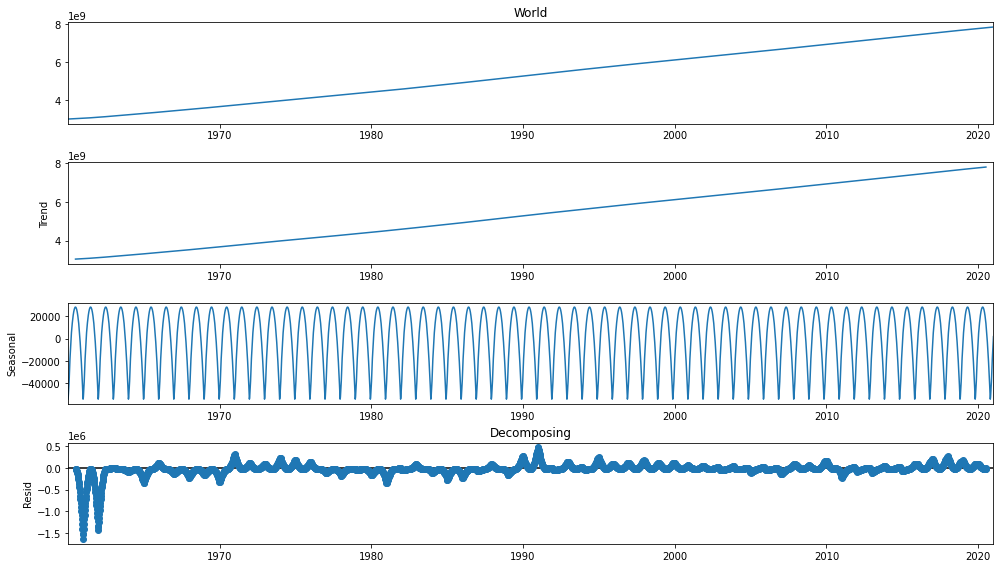

In [74]:
rcParams['figure.figsize'] = 14, 8
decomp_series = sm.tsa.seasonal_decompose(world_pop.World, model='addictive')
decomp_series.plot()
plt.title('Decomposing')
plt.show()

In [9]:
adf_result = adfuller(world_pop.World)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('No. of lags used:', adf_result[2])
print('No. of observations used :', adf_result[3])
if adf_result[1] < 0.05:
    print('TSD is Stationary')
else:
    print('TSD is not Stationary')
print( 'Critical Values:' )
for k, v in adf_result[4].items():
    print( f' {k} : {v} ' )

ADF Statistic: -5.145431525241726
p-value: 1.1351226589609355e-05
No. of lags used: 25
No. of observations used : 3158
TSD is Stationary
Critical Values:
 1% : -3.4324223949823685 
 5% : -2.8624556569780975 
 10% : -2.5672574254233744 


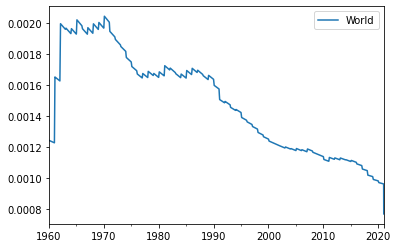

In [231]:
df_log = np.log(world_pop)
df_diff = df_log.diff(periods=5)
df_diff.plot()

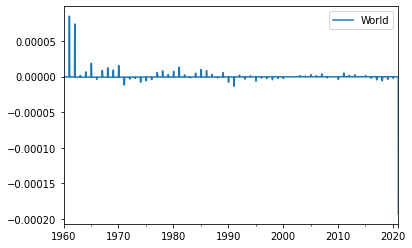

In [232]:
df_diff.isnull().sum()
df_diff = df_diff.diff()
df_diff.fillna(method='bfill', inplace=True)
df_diff.plot()

### Forecasting World's Population

In [233]:
train_df = df_diff.iloc[:1900]
test_df = df_diff.iloc[1900:]
train_df

,World
1960-01-03,-3.089333e-07
1960-01-10,-3.089333e-07
1960-01-17,-3.089333e-07
1960-01-24,-3.089333e-07
1960-01-31,-3.089333e-07
...,...
1996-04-28,-3.697483e-07
1996-05-05,-3.695473e-07
1996-05-12,-3.693464e-07
1996-05-19,-3.691458e-07


#### HoltWinters Exponential Forecast

In [234]:
model = ExponentialSmoothing(train_df['World'],
                             trend='add').fit()

predict = model.forecast(1284)

In [279]:
world_pop

,World
1960-01-03,3.032372e+09
1960-01-10,3.033126e+09
1960-01-17,3.033880e+09
1960-01-24,3.034635e+09
1960-01-31,3.035389e+09
...,...
2020-12-06,7.826137e+09
2020-12-13,7.827646e+09
2020-12-20,7.829155e+09
2020-12-27,7.830664e+09


### Un-Differenced Data

array([3.03237159e+09, 3.03312591e+09, 3.03388022e+09, ...,
       7.82915507e+09, 7.83066411e+09, 7.83066411e+09])

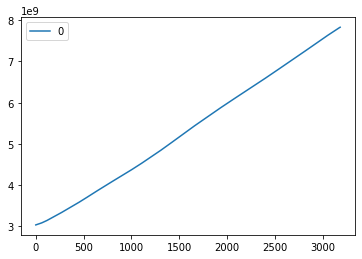

In [277]:
def inv_diff (df_orig_column, df_diff_column, periods):
  value = np.array(df_orig_column[:periods].tolist()+df_diff_column[periods:].tolist())
  inv_diff_vals = diff_inv(value, periods, 1)[periods:]
  #---------------------------------------------------------------
  value = np.array(df_orig_column[:periods].tolist()+inv_diff_vals[periods:].tolist())
  inv_diff_vals = diff_inv(value, periods, 1)[periods:]
  global idv
  idv = pd.DataFrame(inv_diff_vals)
  idv.plot()
  return inv_diff_vals

inv_diff(world_pop.World, df_diff.World, 6000)

In [278]:
undiff_df = idv.rename(columns={0: 'World'})
undiff_df.set_index(world_pop.index, inplace=True)

px.line(undiff_df, undiff_df.index, 'World')


In [207]:
fig = px.line(train_df, train_df.index, 'World')
fig.add_scatter(x=test_df.index, y=test_df.World, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show()

##### metrics

In [208]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, accuracy_score
mape = mean_absolute_percentage_error(test_df, predict)
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df), np.array(predict)))
print('%.2f'%rmse, 'RMSE')

0.74 MAPE
0.00 RMSE


#### ACF and PACF

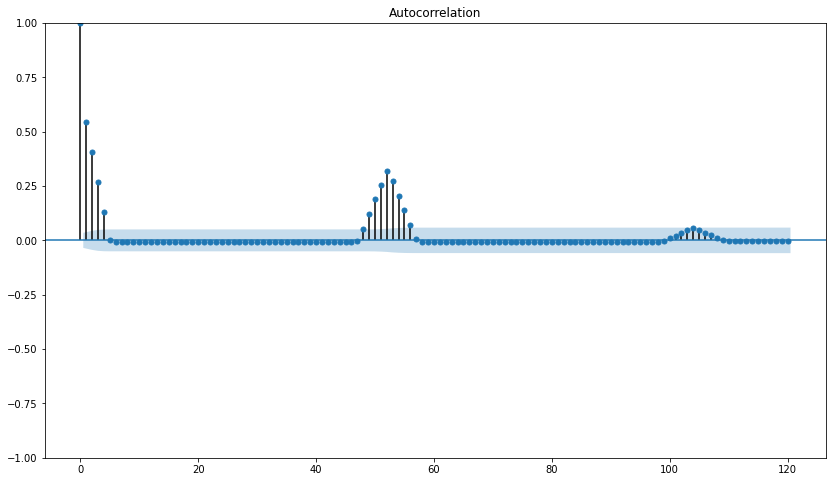

In [110]:
plot_acf(world_pop, lags=120)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



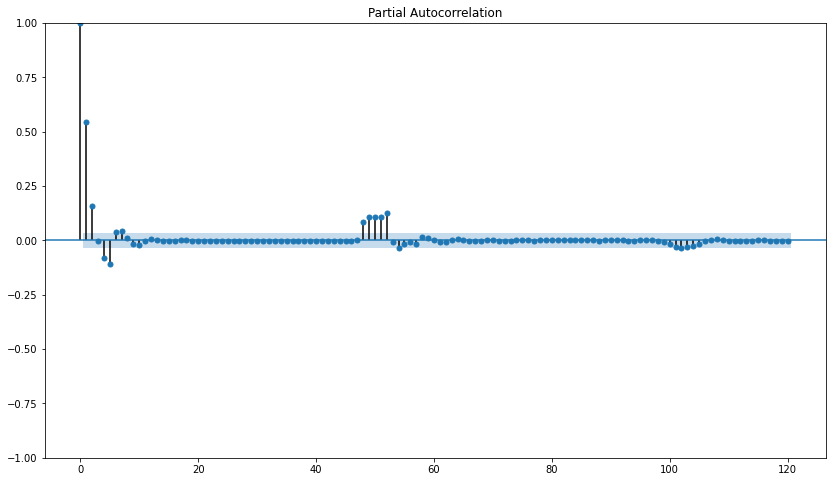

In [111]:
plot_pacf(world_pop, lags=120)
plt.show()

#### ARIMA Forecast

In [9]:
ar_model = ARIMA(train_df['World'], order=(2,0,1)).fit()
start = len(train_df)
stop = len(train_df) + len(test_df) -1

predict = ar_model.predict(start=start, end=stop, dynamic=True)
fig = px.line(train_df, train_df.index, 'World', labels={'x':'Date'})
fig.add_scatter(x=test_df.index, y=test_df.World, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show()

##### metrics


In [10]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df, predict)
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df), np.array(predict)))
print('%.2f'%rmse, 'RMSE')

10.76 MAPE
0.00 RMSE


#### FBProphet Forecast

In [116]:
world_pop.reset_index(inplace=True)
world_pop = world_pop.rename(columns={'index': 'ds', 'World': 'y'})
world_pop

,ds,y
0,1960-01-03,-3.089333e-07
1,1960-01-10,-3.089333e-07
2,1960-01-17,-3.089333e-07
3,1960-01-24,-3.089333e-07
4,1960-01-31,-3.089333e-07
...,...,...
3179,2020-12-06,-1.861151e-07
3180,2020-12-13,-1.860434e-07
3181,2020-12-20,-1.859716e-07
3182,2020-12-27,-1.858999e-07


In [117]:
train_df = world_pop.iloc[:2000]
test_df = world_pop.iloc[2000:]
test_df

model = Prophet()
model.fit(train_df)
forecast = model.predict(test_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


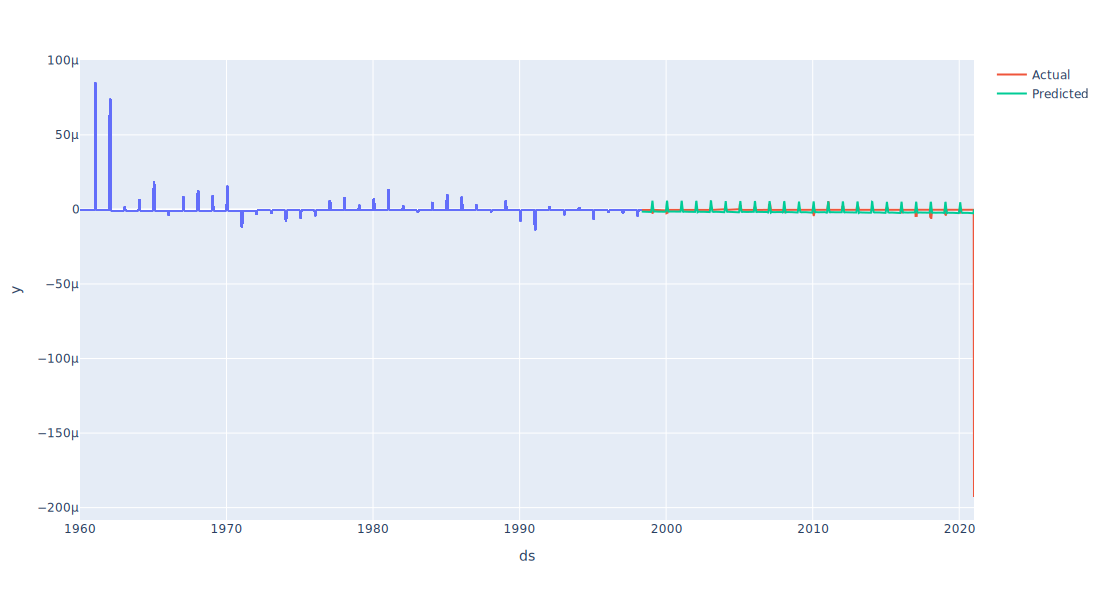

In [118]:
fig = px.line(train_df, train_df.ds, 'y', labels={'x':'Date'})
fig.add_scatter(x=test_df.ds, y=test_df.y, name='Actual')
fig.add_scatter(x=forecast.ds, y=forecast.yhat, name='Predicted')
fig.show('svg', height=600, width=1100)

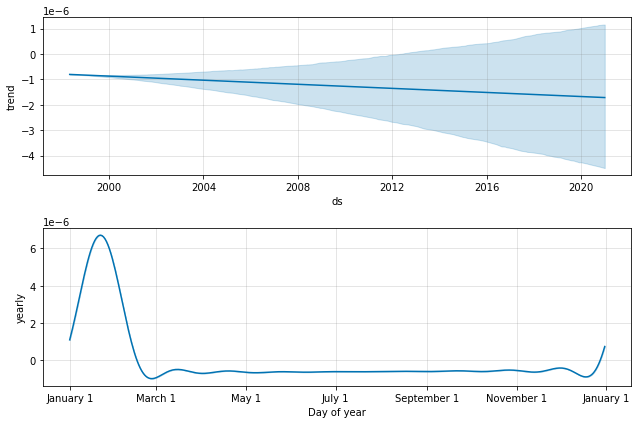

In [119]:
model.plot_components(forecast)
plt.show()

##### metrics

In [120]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df['y'], forecast['yhat'])
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df['y']), np.array(forecast['yhat'])))
print('%.2f'%rmse, 'RMSE')

7.65 MAPE
0.00 RMSE
